# Funções
Funções gerais para auxílio na implementação do exemplo do TSP

In [ ]:
!pip install mip

In [ ]:
from mip import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
def parse_atsp_file(file_content):
    """
    Parse a .tsp file with ATSP (Asymmetric Traveling Salesman Problem) format.
    Returns the dimension (number of nodes) and a matrix of edge weights.
    """
    lines = file_content.strip().splitlines()
    dimension = 0
    edge_matrix = []

    reading_matrix = False

    for line in lines:
        line = line.strip()

        if line.startswith("DIMENSION"):
            dimension = int(line.split(":")[1].strip())

        elif line.startswith("EDGE_WEIGHT_SECTION"):
            reading_matrix = True
            current_row = []

        elif reading_matrix:
            # Append numbers to the current row
            numbers = list(map(int, line.split()))
            current_row.extend(numbers)

            # When the row is complete, append it to the matrix and reset current_row
            if len(current_row) == dimension:
                edge_matrix.append(current_row)
                current_row = []

            # Stop reading when the matrix is complete
            if len(edge_matrix) == dimension:
                break

    return dimension, edge_matrix

In [ ]:
def plot_tsp_solution(adj_matrix):
    """
    Plota um grafo direcionado dado a matriz de adjacência. O rótulo dos nó é o índice dele na matriz.

    :param adj_matrix: Matriz de adjacência do grafo direcionado, e.g., [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
    """
    # Criar um grafo direcionado a partir da matriz de adjacência
    G = nx.DiGraph()

    num_nodes = len(adj_matrix)

    # Adicionar nós e arestas ao grafo
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i][j].x > 0:
                G.add_edge(i, j)

    # Posicionar os nós usando o layout circular
    pos = nx.circular_layout(G)

    # Criar rótulos para os nós
    labels = {i: str(i) for i in range(num_nodes)}

    # Plotar o grafo
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_size=300, node_color='skyblue', edge_color='black', font_size=12,
            font_weight='bold', width=1.5, arrows=True, arrowstyle='-|>', arrowsize=20)

    plt.axis('off')
    plt.show()

In [ ]:
def show_results(model):
  print(f"Objective Value: {model.objective_value}")
  print()
  for var in model.vars:
      if var.x > 0.5:  # Checar se a variável é próxima de 1 (considerando um valor binário)
          print(f"{var.name} = {var.x}")
  return

In [ ]:
def find_cycles(adj_matrix):
    """
    Identifica subciclos em um grafo a partir de uma matriz de adjacência binária.

    :param adj_matrix: Matriz de adjacência do grafo (lista de listas).
    :return: Lista de listas contendo os nós de cada subciclo.
    """
    def dfs(v, visited, stack, path):
        visited[v] = True
        stack[v] = True
        path.append(v)

        for i in range(len(adj_matrix)):
            if adj_matrix[v][i].x == 1:
                if not visited[i]:
                    dfs(i, visited, stack, path)
                elif stack[i]:  # Um ciclo foi encontrado
                    cycle_start = path.index(i)
                    cycles.append(path[cycle_start:])

        stack[v] = False
        path.pop()

    num_nodes = len(adj_matrix)
    visited = [False] * num_nodes
    stack = [False] * num_nodes
    cycles = []

    for node in range(num_nodes):
        if not visited[node]:
            dfs(node, visited, stack, [])

    return cycles

# TSP Exemplo

O TSP (travelling salesman problem ou problema do caixeiro viajante) é um problema complexo de aplicação em muitas áreas. Iremos analisar um pequeno exemplo desse problema para podermos entender como é possível de resolver ele através da PLI.

Esse problema consiste em determinar o menor ciclo (com menor custo, seja ele financeiro, distância, tempo, etc.) para se percorrer $n$ cidades diferentes. Cada cidade possui ligação com as outras, e não é possível voltar em cidades já visitadas. No fim desejamos voltar para a cidade de onde saímos no início.

Abaixo se encontra a entrada em formato padrão para o nosso problema contendo 10 nós (cidades) conectados entre si. Iremos executar um dos algoritmos utilizados para resolver o TSP.

In [ ]:
# Instância tsp a ser utilizada
file_content = """
NAME: tsp_10_nodes
TYPE: ATSP
DIMENSION: 10
EDGE_WEIGHT_TYPE: EXPLICIT
EDGE_WEIGHT_FORMAT: FULL_MATRIX
EDGE_WEIGHT_SECTION
0 10 15 20 25 30 35 40 45 50
10 0 18 22 27 33 37 43 48 55
15 18 0 25 30 35 40 45 50 55
20 22 25 0 28 32 43 48 53 58
25 27 30 28 0 33 47 52 57 62
30 33 35 32 33 0 40 48 55 60
35 37 40 43 47 40 0 38 45 52
40 43 45 48 52 48 38 0 42 49
45 48 50 53 57 55 45 42 0 50
50 55 55 58 62 60 52 49 50 0
EOF

"""

Podemos representar esse problema através de um grafo, e é exatamente isso o que faremos. A variável `edge_matrix` é uma matriz de adjacência contendo a ligação entre as cidades do problema e o custo (distância) para ir de uma cidade a outra.

In [ ]:
# Parse o arquivo .tsp
dimension, edge_matrix = parse_atsp_file(file_content)

A resolução do nosso problema é a seguinte: criamos um modelo que exigirá que todas as cidades sejam percorridas, ou seja, o ciclo final terá que passar por todas as cidades. Assim todas elas serão percorridas e a condição do problema será satisfeita.

Para fazermos isso, iremos impor que, para cada cidade em nosso problema, seja necessário que exista um arco que chegue e um arco que saia dela na solução. Para isso, iremos definir uma variável binári $x_{ij}$ irá determinar se o arco que vai do nó $i$ para o nó $j$ está sendo utilizado.

Logo, temos como restrições

$\sum_{i} x_{ij} == 1,  ~\forall j$

$\sum_{i} x_{ji} == 1,  ~\forall j$

onde a primeira está dizendo que todo nó $j$ deve ter um arco que vai até ele e a segunda diz que todo nó $j$ deve ter um arco que sai dele na solução.  

Solution value  =  333.0


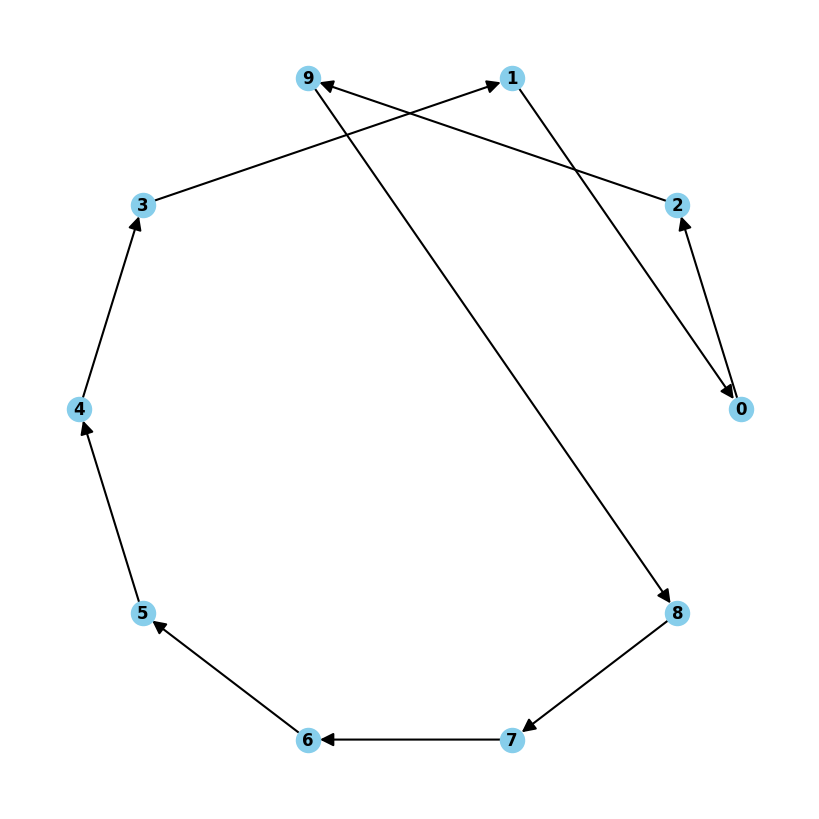

In [ ]:

model = Model(sense=MINIMIZE, solver_name=CBC)

x = [[model.add_var(var_type=BINARY, name=f"x_{i}_{j}") for j in range(dimension)] for i in range(dimension)]

model.objective += sum(edge_matrix[i][j]*x[i][j] for j in range(dimension) for i in range(dimension))

for j in range(dimension):
  model += sum(x[i][j] for i in range(dimension) if i!= j) ==1
for j in range(dimension):
  model += sum(x[j][i] for i in range(dimension) if i!= j) ==1

while len(find_cycles(x)) != 1:
    t = find_cycles(x)
    n = len(t)
    for i in range(n):
        m = len(t[i])
        model += sum(x[p][g] for g in t[i]  for p in t[i] if g != p) <= m-1
    model.optimize()

print("Solution value  = ", model.objective_value)
plot_tsp_solution(x)


No entanto, nem tudo são flores. Em nenhum momento as restrições acima obrigam que a solução seja um único ciclo no grafo. Ou seja, as restrições não obrigam que no ciclo gerado seja possível sair de um nó e chegar em qualquer outro nó do grafo. Por conta disso, a chance de que subciclos no grafo sejam gerados é alta. Por isso, iremos para a segunda parte do algoritmo para resolver o TSP.

Nessa parte, devemos avaliar a resposta do resolvedor e analisar se ela contém um único ciclo. No nosso caso, possuímos 5 subciclos diferentes em nossa resposta. Podemos ver isso abaixo no grafo que representa a solução encontrada.

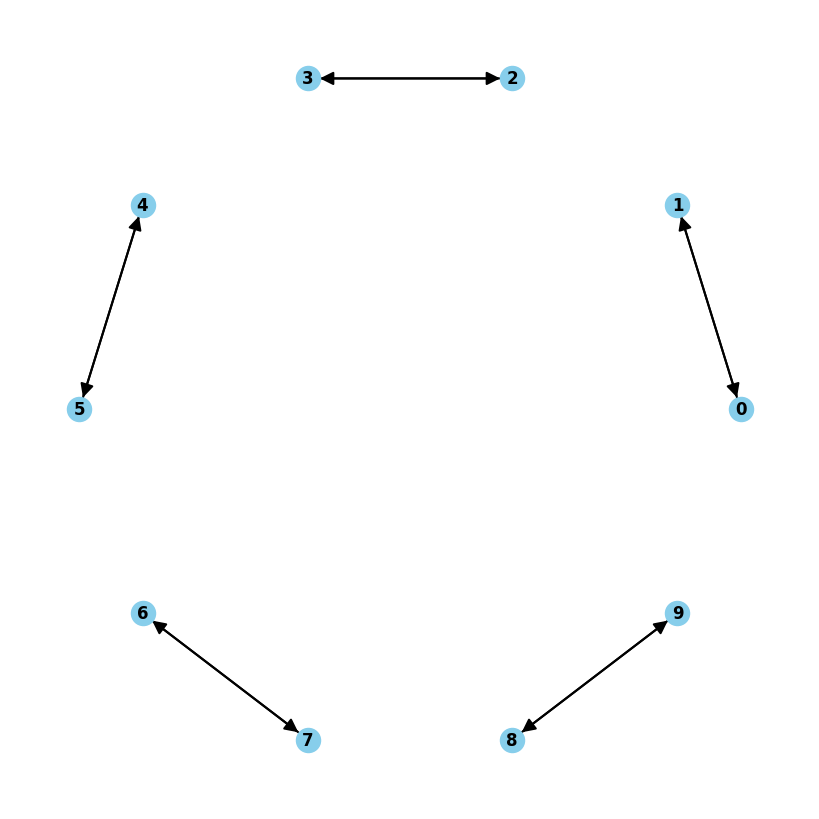

In [ ]:
plot_tsp_solution(x)

Para resolvermos esse problema, precisamos proibir que esses subciclos possam ser gerado pelo resolvedor. Para  isso, denotamos por $S$ o conjunto que contém os nós do subciclo. Iremos adicionar a seguinte restrição:

$\sum_{i ~\in~ S}\sum_{j~ \in~ S : ~j ~\not= ~i} x_{ij} <= |S| - 1$.

A restrição força que, dentre todos os arcos possíveis entre vértices do conjunto $S$, no máximo $|S|-1$ estejam presentes na solução. Isso impede que seja formado qualquer subciclo com os vértices de $S$ (em qualquer ordem, e não apenas na ordem que apareceu na solução).

Dessa forma, iremos adicionar essas restrições ao modelo.

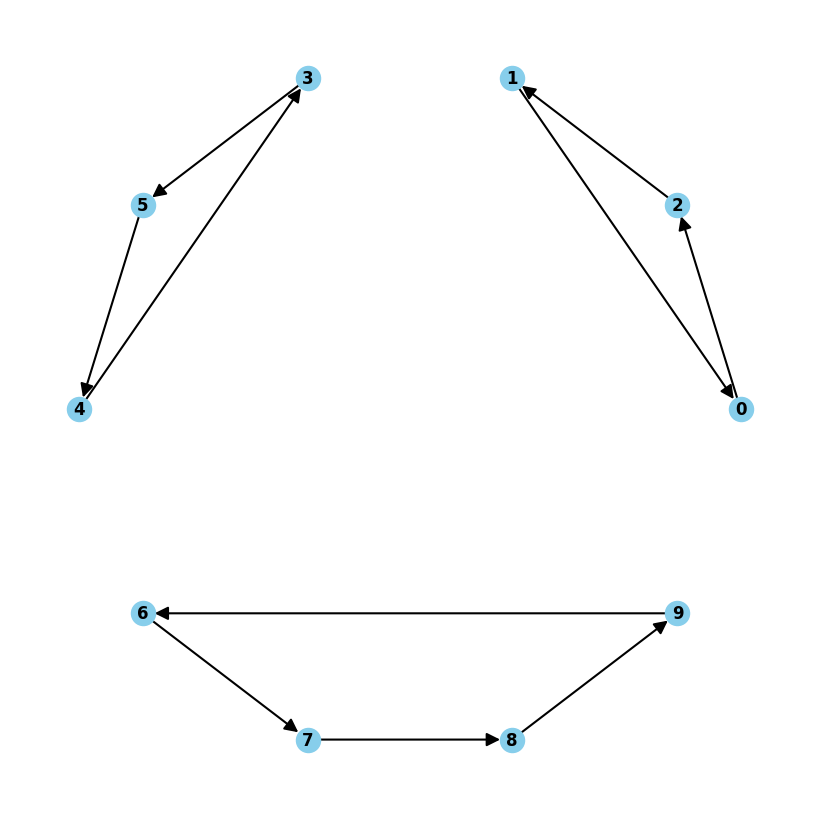

In [ ]:

for i in range(dimension):
  for j in range(dimension):
    model+= x[i][j] + x[j][i]  <=1

model.optimize()

plot_tsp_solution(x)

Infelizmente ainda não obtivemos uma resposta da forma como desejávamos. No entanto, aqueles subciclos da última resolução não foram repetidos.

Solution value  =  333.0
[[0, 2, 9, 8, 7, 6, 5, 4, 3, 1]]


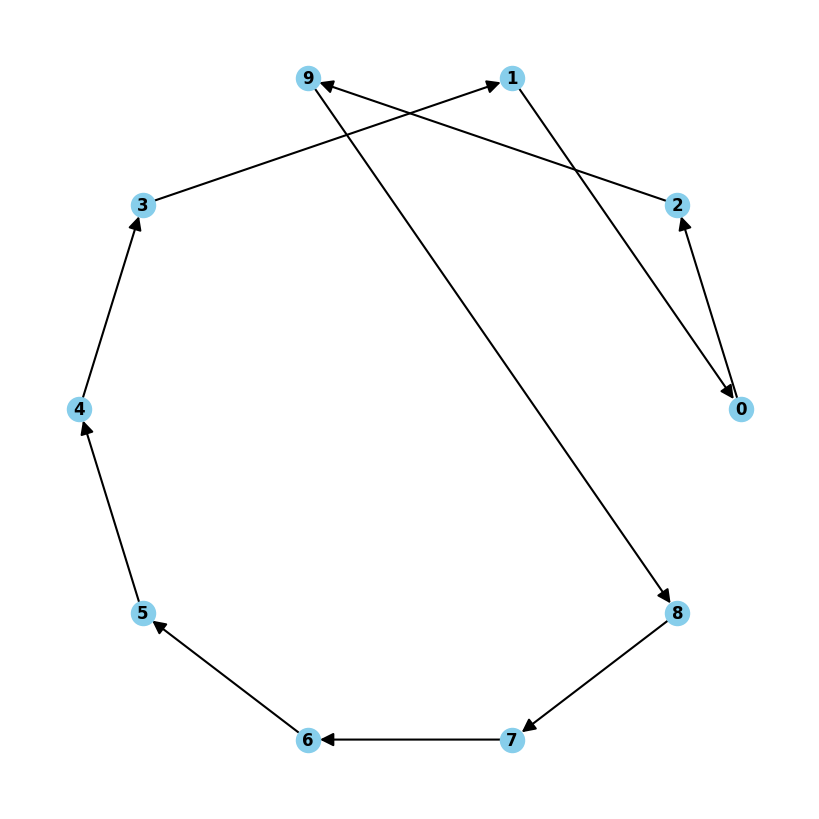

In [ ]:



while len(find_cycles(x)) != 1:

    t = find_cycles(x)
    n = len(t)
    for i in range(n):
        m = len(t[i])
        model += sum(x[p][g] for g in t[i]  for p in t[i] if g != p) <= m-1

    model.optimize()


print("Solution value  = ", model.objective_value)
print(find_cycles(x))
plot_tsp_solution(x)

Solution value  =  333.0


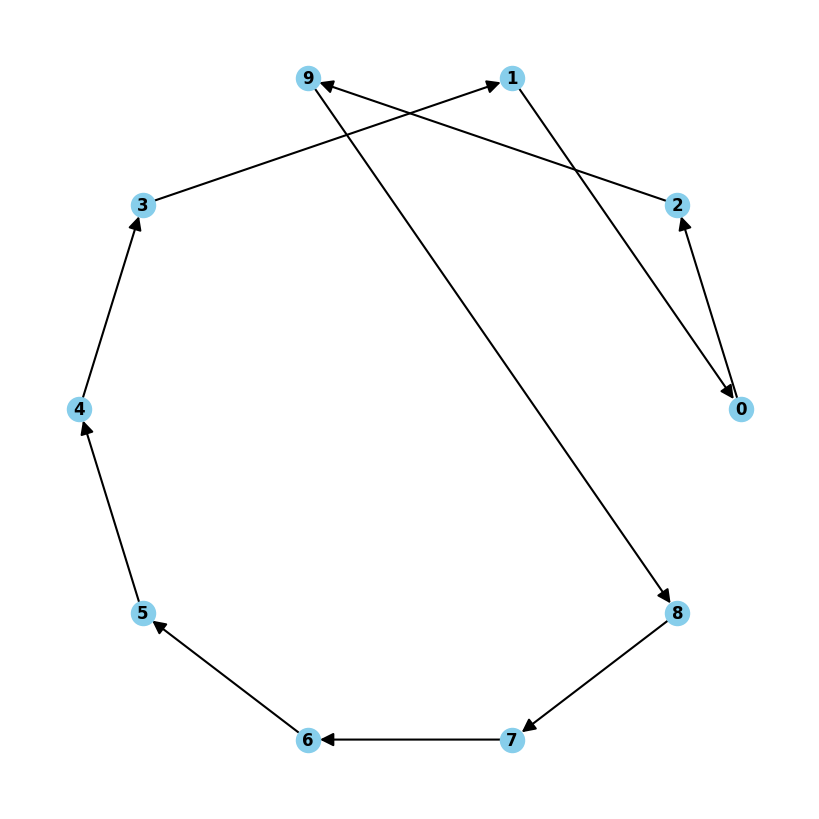

In [ ]:
model += x[0][1] + x[0][2] + x[0][3] + x[0][4] + x[1][0] + x[1][2] + x[1][3] + x[1][4] + x[2][0] + x[2][1] + x[2][3] + x[2][4] + x[3][0] + x[3][1] + x[3][2] + x[3][4] + x[4][0] + x[4][1] + x[4][2] + x[4][3] <= 4
model += x[7][8] + x[7][9] + x[8][7] + x[8][9] + x[9][7] + x[9][8] <= 2
model += x[5][6] + x[6][5] <= 1

model.optimize()
print("Solution value  = ", model.objective_value)
plot_tsp_solution(x)

1


Através desse algoritmo, é possível calcular a solução ótima para o TSP. No entanto, seria impraticável visualizar a solução a cada iteração do algoritmo e então proibir os subciclos contidos nela. Por isso, a execução acima do algoritmo foi feita apenas com fins didáticos. Na realidade, esse algoritmo possui um loop *while* que se encarrega de gerenciar todas as iterações.



# Prática
Agora é com você. Resolva o mesmo problema para as instâncias abaixo fazendo a segunda parte do algoritmo dentro do loop *while*. Você pode utilizar qualquer das funções contidas na aba **Funções** para auxiliá-lo.

**Primeira Instância**

Arquivo: https://www.dropbox.com/scl/fi/lude86d562bapdebn1kah/ft70.atsp?rlkey=fdyoz5mefuf8mwc652or9010p&dl=0

Valor Ótimo: 38673.0

-------------------------------------------------------------------------

**Segunda Instância**

Arquivo: https://www.dropbox.com/scl/fi/748iyf5zubmr08ch3cuyk/kro124p.atsp?rlkey=df91hsx9uyk90u8nyl2cgc174&dl=0

Valor Ótimo: 36230.0



In [ ]:
# Instância tsp a ser utilizada
with open('ft70.atsp', 'r') as arquivo:
    file_content = arquivo.read()

In [ ]:
# Parse do arquivo .tsp
dimension, edge_matrix = parse_atsp_file(file_content)

Primeira parte: definição inicial do modelo.

Solution value  =  38673.0


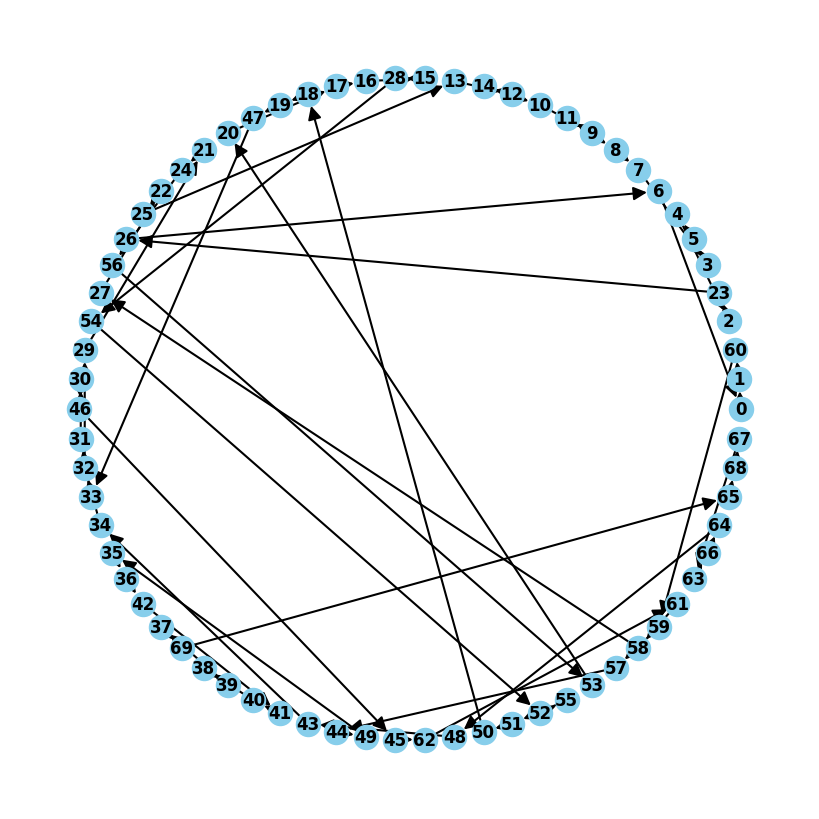

In [ ]:

model = Model(sense=MINIMIZE, solver_name=CBC)

x = [[model.add_var(var_type=BINARY, name=f"x_{i}_{j}") for j in range(dimension)] for i in range(dimension)]

model.objective += sum(edge_matrix[i][j]*x[i][j] for j in range(dimension) for i in range(dimension))

for j in range(dimension):
  model += sum(x[i][j] for i in range(dimension) if i!= j) ==1
for j in range(dimension):
  model += sum(x[j][i] for i in range(dimension) if i!= j) ==1

while len(find_cycles(x)) != 1:
    t = find_cycles(x)
    n = len(t)
    for i in range(n):
        m = len(t[i])
        model += sum(x[p][g] for g in t[i]  for p in t[i] if g != p) <= m-1
    model.optimize()

print("Solution value  = ", model.objective_value)
plot_tsp_solution(x)


Segunda parte: atualização do modelo para garantir que exista apenas um ciclo no grafo contendo a solução.

In [ ]:
# Instância tsp a ser utilizada
with open('kro124p.atsp', 'r') as arquivo:
    file_content = arquivo.read()

In [ ]:
# Parse do arquivo .tsp
dimension, edge_matrix = parse_atsp_file(file_content)

Solution value  =  36230.0


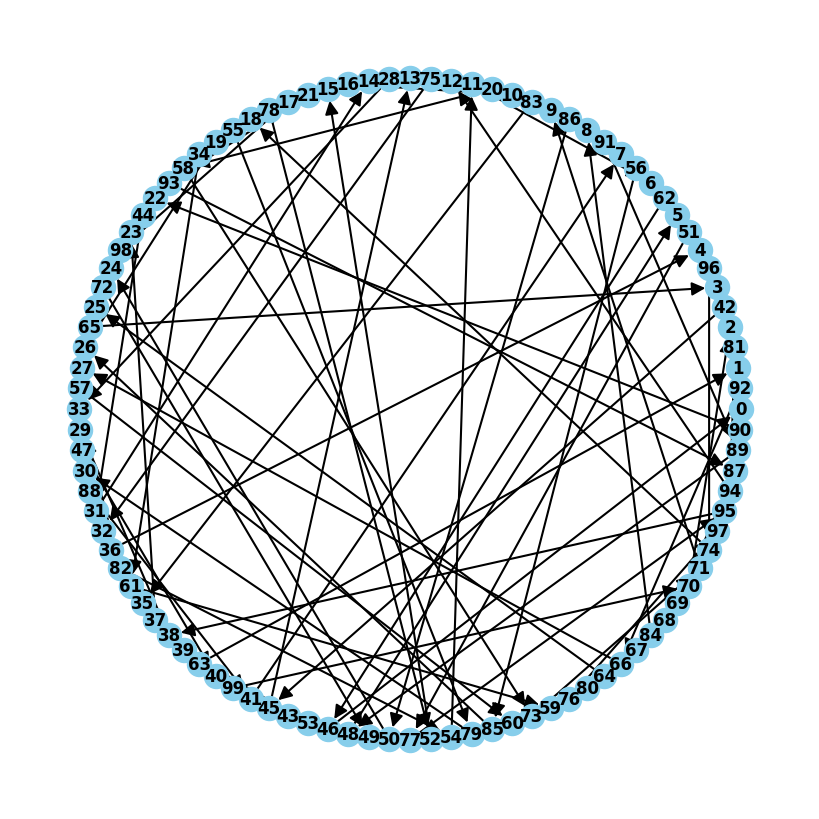

In [ ]:

model = Model(sense=MINIMIZE, solver_name=CBC)

x = [[model.add_var(var_type=BINARY, name=f"x_{i}_{j}") for j in range(dimension)] for i in range(dimension)]

model.objective += sum(edge_matrix[i][j]*x[i][j] for j in range(dimension) for i in range(dimension))

for j in range(dimension):
  model += sum(x[i][j] for i in range(dimension) if i!= j) ==1
for j in range(dimension):
  model += sum(x[j][i] for i in range(dimension) if i!= j) ==1

while len(find_cycles(x)) != 1:
    t = find_cycles(x)
    n = len(t)
    for i in range(n):
        m = len(t[i])
        model += sum(x[p][g] for g in t[i]  for p in t[i] if g != p) <= m-1
    model.optimize()

print("Solution value  = ", model.objective_value)
plot_tsp_solution(x)
